In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import operator
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
%matplotlib inline

In [298]:
data = pd.read_csv('food_final.csv', index_col=0)
data = data[['rating', 'stats.checkinsCount', 'price.tier', 'SCORE']]
data.SCORE.describe()

count    14011.000000
mean        10.311541
std          5.498706
min         -1.000000
25%          7.000000
50%         10.000000
75%         12.000000
max         62.000000
Name: SCORE, dtype: float64

In [299]:
# data cleaning, drop the NAs
data_clean = data[data.SCORE >= 0]
data_clean.dropna(inplace=True)
data_final = data_clean[['SCORE', 'rating',
                         'stats.checkinsCount',
                         'price.tier']]
# make the category labels
def f(x):
    if x < 14:
        return 1
    elif (x >= 14) & (x < 28):
        return 2
    else:
        return 3

data_final['label'] = data_clean.SCORE.apply(lambda x: f(x))
data_final.reset_index(drop=True, inplace=True)
data_final.drop(['SCORE'], axis=1, inplace=True)
data_final['price'] = pd.Series(data_final['price.tier'], dtype=str)

/Users/eliseowang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/eliseowang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [300]:
data_final = pd.get_dummies(data_final)

In [301]:
cols = data_final.columns

In [302]:
cols = cols.drop('label')

In [303]:
# normalize the data (scale 0 - 1)
y = data_final['label']
data_final.drop('label', axis=1, inplace=True)
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(data_final)
X = pd.DataFrame(X, columns = cols)

In [304]:
# create a normalized dataframe
# data_norm = pd.DataFrame(X, columns=data_final.columns[0:3])
# data_norm['label'] = y
# data_norm.head(5)

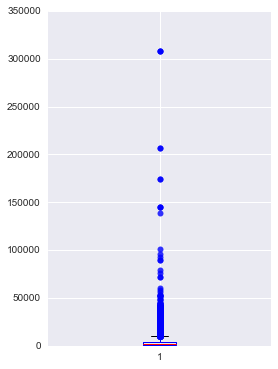

In [305]:
# boxplot of checkin counts to see how the data is distributed and if there is any outlier
fig = plt.figure(1, figsize=(4,6))
ax = fig.add_subplot(111)
bp = ax.boxplot(x=data_final['stats.checkinsCount'], showfliers=True)
for flier in bp['fliers']:
    flier.set(marker = 'o', c='#7570b3', alpha=0.8)
plt.show()

In [306]:
# split the data into train, validation and test sets
data_train, data_test = train_test_split(X, test_size=0.3, random_state=2016)
data_train, data_valid = train_test_split(data_train, test_size=0.4, random_state=2016)
X_train = data_train
y_train = y.loc[data_train.index]
X_valid = data_valid
y_valid = y.loc[data_valid.index]
X_test = data_test
y_test = y.loc[data_test.index]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ..., 
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [307]:
cls = MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)
cls.fit(X, y)
res = cls.predict(X_valid)
1 - (1.0*np.count_nonzero(res - y_valid) / len(res))

0.8943067284118769

In [308]:
def NBclassifier(X, y, X_valid, y_valid, alpha, class_prior, fit_prior):
    cls = MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)
    cls.fit(X, y)
    res = cls.predict(X_valid)
    accu = 1 - (1.0*np.count_nonzero(res - y_valid) / len(res))
    return accu

In [309]:
alpha = [pow(10, i) for i in np.linspace(-5, 5, 300)]
res = {}
for i in alpha:
    res[i] = NBclassifier(X_train, y_train,
                          X_valid, y_valid,
                          alpha=i, class_prior=None,
                          fit_prior=None)

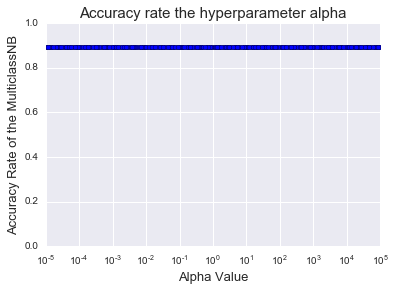

In [310]:
fig, ax = plt.subplots()
ax.scatter(x=res.keys(), y=res.values())
ax.set_xscale('log')
ax.set_xlim(left=pow(10, -5), right=pow(10,5))
ax.set_ylim(bottom=0, top=1)
ax.set_title('Accuracy rate the hyperparameter alpha', fontsize=15)
ax.set_xlabel('Alpha Value', fontsize=13)
ax.set_ylabel('Accuracy Rate of the MulticlassNB', fontsize=13)

# The problem here is that the naive bayes classifier has classified all the restaurants as A-graded. It's probably due to the fact that the majority of the results are labeled A in the first place.

# I will try a decision tree instead

In [311]:
# X = data_final[['rating', 'stats.checkinsCount', 'price.tier']]
# X.reset_index(inplace=True)
# y = data_final['label']
# y = preprocessing.label_binarize(y, classes=[1, 2, 3])
# X_train, X_test = train_test_split(X, test_size=0.3, random_state=2016)
# y_train = y[X_train.index]
# y_test = y[X_test.index]

In [323]:
data_train.shape[0], data_valid.shape[0]
y_prep = preprocessing.label_binarize(y, classes=[1, 2, 3])

In [367]:
# X_train = pd.concat([data_train, data_valid], axis=0)
y_train = y_prep[data_train.index]
y_valid = y_prep[data_valid.index]
y_test = y_prep[X_test.index]

In [383]:
y_better_train = np.concatenate([y_train, y_valid], axis=0)

In [327]:
random.seed(2016)
dtm = tree.DecisionTreeClassifier()
dtm = dtm.fit(X_train, y_train)
val = dtm.predict(X_test)

In [328]:
# calculate accuracy
ls = []
for i in zip(y_test, val):
    ls.append(np.array_equal(i[0], i[1]))
accu = ((1.0 * np.array(ls)).sum()) / len(ls)
print 'The accuracy for this vanila model is {0:.4f}.'.format(accu)
print 'The AUC score is {0:.4f}'.format(roc_auc_score(y_test, val))

The accuracy for this vanila model is 0.7855.
The AUC score is 0.5169


In [345]:
feature_importances = list(dtm.feature_importances_)
feature_dic = {}
for i, j in zip(X_test.columns, feature_importances):
    feature_dic[i] = j
fl = sorted(feature_dic.items(), key=operator.itemgetter(1), reverse=True)
for i in fl:
    print i

('stats.checkinsCount', 0.63620243570945234)
('rating', 0.30300619410180907)
('price_2.0', 0.01938978043396317)
('price_3.0', 0.017426891657130225)
('price.tier', 0.013818628787529584)
('price_1.0', 0.010156069310115614)
('price_4.0', 0.0)


In [370]:
leafNum = []
accu = []
for i in range(2, 101):
    dtm = DecisionTreeClassifier(max_leaf_nodes=i)
    dtm.fit(data_train, y_train)
    leafNum.append(roc_auc_score(y_valid, dtm.predict(X_valid)))
    ls = []
    for j in zip(y_valid, dtm.predict(X_valid)):
        ls.append(np.array_equal(j[0], j[1]))
    accu.append((1.0 * np.array(ls)).sum() / len(ls))

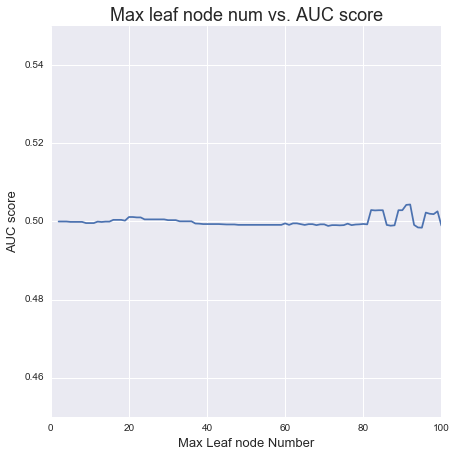

In [371]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(range(2, 101), leafNum)
# for i in x_time.index:
#     ax.annotate('period {0}'.format(i), xy = (x_time[i]+0.001, y_time[i]), color='#FF00FF')
ax.set_ylim(bottom=0.45, top=0.55)
ax.set_title('Max leaf node num vs. AUC score', fontsize=18)
ax.set_xlabel('Max Leaf node Number', fontsize=13)
ax.set_ylabel('AUC score', fontsize=13)

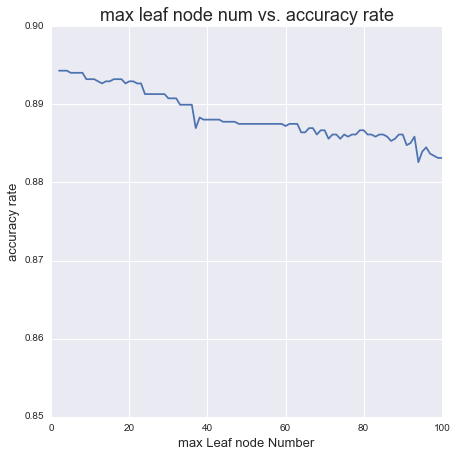

In [372]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(range(2, 101), accu)
# for i in x_time.index:
#     ax.annotate('period {0}'.format(i), xy = (x_time[i]+0.001, y_time[i]), color='#FF00FF')
ax.set_ylim(bottom=0.85, top=0.9)
ax.set_title('max leaf node num vs. accuracy rate', fontsize=18)
ax.set_xlabel('max Leaf node Number', fontsize=13)
ax.set_ylabel('accuracy rate', fontsize=13)

In [384]:
dtm = DecisionTreeClassifier(max_leaf_nodes=2)
dtm.fit(X_train, y_better_train)
dtm.predict(X_test)

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [385]:
print roc_auc_score(y_test, dtm.predict(X_test)), 

0.5

In [386]:
ls = []
for j in zip(y_test, dtm.predict(X_test)):
    ls.append(np.array_equal(j[0], j[1]))
print (1.0 * np.array(ls)).sum() / len(ls)

0.886883579054


In [389]:
print dtm.feature_importances_

[ 0.  1.  0.  0.  0.  0.  0.]


In [388]:
data.columns

Index([u'rating', u'stats.checkinsCount', u'price.tier', u'SCORE'], dtype='object')

In [15]:
export_graphviz(dtm, out_file='decisionTree.dot')

In [16]:
# split training, validation and test data
# random.seed(2016)
# cross_validation.train_test_split()
# ind = stats.bernoulli.rvs(p=0.7, size=len(data_final.index))
# train = data_norm[ind == 1]
# test = data_norm[ind == 0]
# valid = 

In [44]:
# from IPython.display import Image
# dot_data = StringIO()
# export_graphviz(dtm, out_file=dot_data,
#                 feature_names=X_train.columns)
# graph = pydot.graph_from_dot_data(dot_data.getvalue())
# Image(graph.create_png())